In [1]:
using LinearAlgebra, Test, DifferentialEquations, SparseArrays, Plots

In [2]:
# get Q in matrix form for sanity check
function get_Q_matrix(N, θ)
    # intermediate vals
    N_total = 2*N;
    setsize = (N+1)^2;
    function get_row_block(d_i,a)    
        # note that all rows sum up to zero by construction
        dl_block = -(z->((N_total-z)/N_total)*θ(a)).(d_i:(d_i+N))
        d_block = -dl_block/2
        du_block = -dl_block/2
        if (d_i == N) # there's no diffusion to 2nd cohort in the last block
            dl_block = dl_block/2
        end

        mat = spdiagm(0 => dl_block, 1 => d_block, (1+N)=>du_block) 

        # modify the last row, where first cohort products are fully recognized
        mat[(N+1),(N+2)] = 0.0
        mat[(N+1),end] *= 2 
        mat[(N+1),:] /= 2 # if departure rate is halved for full recognized state

        # fill the rest in row block with zeros
        if (d_i == 0)
            return [mat[1:(N+1),:] zeros(N+1, (N+1)*(N-1))]
        elseif (d_i >= (N-1))
            return [zeros(N+1, d_i*(N+1)) mat[1:(N+1),:]][:,1:setsize]
        else
            return [zeros(N+1, d_i*(N+1)) mat[1:(N+1),:] zeros(N+1, (N-1-d_i)*(N+1))]
        end
    end
    # generate model
    return a -> vcat(get_row_block.(0:N, a)...)
end

# solve model with matrix Q
function solve_transition_dynamics_matrix(Q_matrix, f_0, T)
    # solve transition dynamics given 
    # Q; N by N matrix generator
    # f_0; N vector of initial distribution
    # T; Float64 terminal time
    df(f,p,a) = Q_matrix(a)' * f
    prob = DifferentialEquations.ODEProblem(df,f_0,(0.0,T))
    return solve(prob);
end


solve_transition_dynamics_matrix (generic function with 1 method)

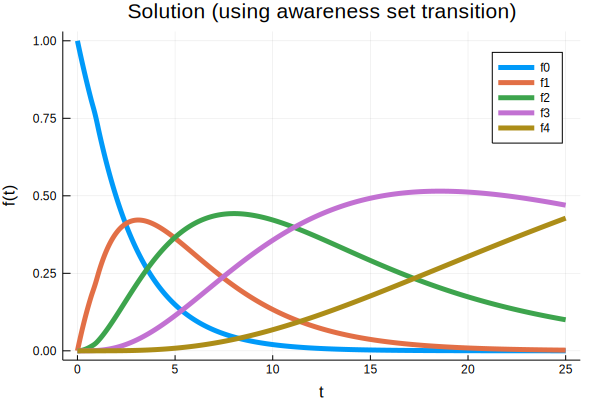

In [3]:
# two firms per cohort
t_2 = 1.0
θ_1 = 0.3
θ_2 = 0.4
θ(t) = t < t_2 ? θ_1 : θ_2
t = 0.0
N = 2
T = 25.0

# define generator
Q = get_Q_matrix(N, θ)

# solve the corresponding ODE
f_0 = [1.0; fill(0.0, (N+1)^2-1)]
sol_awareness = solve_transition_dynamics_matrix(Q, f_0, T)


# convert to the counting solution
f0_awareness(a) = sol_awareness(a)[1] # no product
# 1.1 or 2.1
f1_awareness(a) = sol_awareness(a)[2] + sol_awareness(a)[4] 
# 1.1+1.2 or 1.1+2.1 or 2.1+2.2
f2_awareness(a) = sol_awareness(a)[3] + sol_awareness(a)[5] + sol_awareness(a)[7]
# 1.1+1.2+2.1 or 1.1+2.1+2.2
f3_awareness(a) = sol_awareness(a)[6] + sol_awareness(a)[8] 
# 1.1+1.2+2.1+2.2
f4_awareness(a) = sol_awareness(a)[9]

# plot
plot(0:0.01:T, [f0_awareness, f1_awareness, f2_awareness, f3_awareness, f4_awareness],linewidth=5,
    title="Solution (using awareness set transition)",
     xaxis="t",yaxis="f(t)",label=["f0" "f1" "f2" "f3" "f4"])

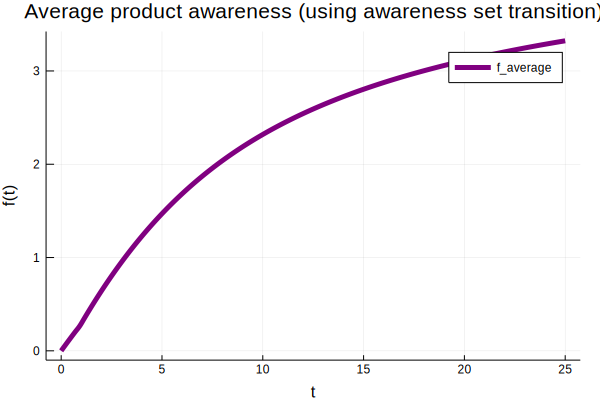

In [4]:
f_awareness(a) = dot(0:(N*2), [f0_awareness(a); f1_awareness(a); f2_awareness(a); f3_awareness(a); f4_awareness(a)]) # average product awareness
plot(0:0.01:T, f_awareness, linewidth=5,
    title="Average product awareness (using awareness set transition)",
    xaxis="t",yaxis="f(t)",label=["f_average"],linecolor="purple")

In [5]:
# sanity checks
# all row sum should be zero
@test all(Q(0.0)*ones((N+1)^2,1) .== 0.0) 
# check if there is no forgetting, i.e., f_count is increasing.
@test all(diff(f_awareness.(range(0.0, stop = T, length = 50))) .> 0)
# check if f is a probability distribution for all t in (0, T)
@test all(sum.(sol_awareness.(range(0.0, stop = T, length = 50))) .≈ 1.0)

Test Passed